For questions about using the API, see https://quickstats.nass.usda.gov/api

In [1]:
import json
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
def get_data(years, states='all'):
    """
    Retrieves data from NASS USDA Quick Stats API. 
    
    Feel free to change what is in the config_url to pull different data, 
    and feel free to change the columns that are displayed in the output df.
    Available features are listed in the docs above.
    NOTE: If a requested state has no data for a given year, it is simply skipped.
    
    Args:
        years (list): List of years to retrive. 
        states (list or str): List of states to retrieve, or 'all'
    
    Returns:
        (DataFrame): dataframe concatenated by state then year
    """
    api_key = '986A28EC-EF35-31C1-A179-461CF9DF4F8E'
    root_url = 'http://quickstats.nass.usda.gov/api/api_GET/?key={}'.format(api_key)
    
    if states == 'all':
        states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
                  "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
                  "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
                  "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
                  "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
        
    all_dfs = []
    with tqdm(total=len(years)*len(states)) as pbar:
        for year in years:
            for state in states:
                # Parameters
                source_desc = 'SURVEY' # Program
                sector_desc = 'CROPS' # Sector
                group_desc = 'FIELD CROPS' # Group
                agg_level_desc = 'COUNTY' # Geographical Level
                year = year # Year
                freq_desc = 'ANNUAL' # Period Type
                reference_period_desc = 'YEAR' # Period
                statisticcat_desc = 'AREA HARVESTED' # Data Item
                state_alpha = state

                params = [source_desc, sector_desc, group_desc, agg_level_desc,
                          year, freq_desc, reference_period_desc, statisticcat_desc,
                          state_alpha]

                config_url = '&source_desc={}'\
                             '&sector_desc={}'\
                             '&group_desc={}'\
                             '&agg_level_desc={}'\
                             '&year={}'\
                             '&freq_desc={}'\
                             '&reference_period_desc={}'\
                             '&statisticcat_desc={}'\
                             '&state_alpha={}'.format(*params)

                response = requests.get(root_url + config_url)
                if response.status_code == 200:
                    data = json.loads(response.content.decode('utf-8'))
                    df = pd.DataFrame(data['data'])

                    ###########################################################################
                    # If you want to change the output dataframe, change this list of columns. 
                    # Possible columns can be found at the above URL under "Usage"
                    ###########################################################################
                    df['fips_code'] = df['state_fips_code'] + df['county_code'] # Note: This might not actually be a valid FIPS code in some cases
                    columns = ['year', 'fips_code', 'state_alpha', 
                               'county_name', 'commodity_desc', 'unit_desc', 'Value','short_desc']
                    df = df[columns]
                    df = df.rename(columns={'Value':'value'})
                    df = df.sort_values(by=['fips_code', 'commodity_desc'])

                    all_dfs.append(df)
                pbar.update()
                
    return pd.concat(all_dfs, ignore_index=True)

df = get_data(years=np.arange(1900, 2021), states=['ND'])

100%|██████████| 121/121 [08:46<00:00,  4.35s/it]


In [3]:
df.head()

,year,fips_code,state_alpha,county_name,commodity_desc,unit_desc,value,short_desc
0,1919,38001,ND,ADAMS,BARLEY,ACRES,"3,000",BARLEY - ACRES HARVESTED
1,1919,38001,ND,ADAMS,CORN,ACRES,"6,000","CORN, GRAIN - ACRES HARVESTED"
2,1919,38001,ND,ADAMS,FLAXSEED,ACRES,"3,000",FLAXSEED - ACRES HARVESTED
3,1919,38001,ND,ADAMS,HAY,ACRES,"13,000","HAY, ALFALFA - ACRES HARVESTED"
4,1919,38001,ND,ADAMS,OATS,ACRES,"15,000",OATS - ACRES HARVESTED


In [4]:
df.to_csv('crop_county_data.csv')

In [5]:
df[df.value == '                 (D)'] = np.NaN
df.dropna()
df['value'] = df['value'].str.replace(',','')
print(df.tail())
df['value'] = df['value'].astype('float64')
df.head()

          year fips_code  ...   value                                     short_desc
103242  2020.0     38998  ...   44750                     SOYBEANS - ACRES HARVESTED
103243  2020.0     38998  ...  144900          SUNFLOWER, OIL TYPE - ACRES HARVESTED
103244  2020.0     38998  ...  171100  WHEAT, SPRING, (EXCL DURUM) - ACRES HARVESTED
103245  2020.0     38998  ...  251080         WHEAT, SPRING, DURUM - ACRES HARVESTED
103246  2020.0     38998  ...   33000                WHEAT, WINTER - ACRES HARVESTED

[5 rows x 8 columns]


,year,fips_code,state_alpha,county_name,commodity_desc,unit_desc,value,short_desc
0,1919.0,38001,ND,ADAMS,BARLEY,ACRES,3000.0,BARLEY - ACRES HARVESTED
1,1919.0,38001,ND,ADAMS,CORN,ACRES,6000.0,"CORN, GRAIN - ACRES HARVESTED"
2,1919.0,38001,ND,ADAMS,FLAXSEED,ACRES,3000.0,FLAXSEED - ACRES HARVESTED
3,1919.0,38001,ND,ADAMS,HAY,ACRES,13000.0,"HAY, ALFALFA - ACRES HARVESTED"
4,1919.0,38001,ND,ADAMS,OATS,ACRES,15000.0,OATS - ACRES HARVESTED


In [6]:
"""county_dict is a dictionary containing the name of the county as the key and a dataframe for the county as a value"""
county_dict = {}
for county in df.county_name.unique():
    data = df[df['county_name']==county]
    county_dict.update({county:data})

# The splitter returns a subset of the data based on years and crop type

In [7]:
print(df['commodity_desc'].unique())

['BARLEY' 'CORN' 'FLAXSEED' 'HAY' 'OATS' 'RYE' 'WHEAT' 'SOYBEANS'
 'SUGARBEETS' 'SUNFLOWER' 'BEANS' 'CANOLA' 'PEAS' 'LENTILS' nan]


In [8]:
def splitter(county,year_max,year_min,crop,desc=None):
    sub = county_dict[county]
    if desc != None:
        crop = sub.loc[(sub['year']>=year_min)&(sub['year']<=year_max) & (sub['commodity_desc'] == crop) & (sub['short_desc'] == desc)]
    else:
        crop = sub.loc[(sub['year']>=year_min)&(sub['year']<=year_max) & (sub['commodity_desc'] == crop)]
    crop.set_index('year',inplace = True)
    return crop

In [9]:
corngraph = splitter('BARNES',2020,1900,'CORN','CORN, GRAIN - ACRES HARVESTED')

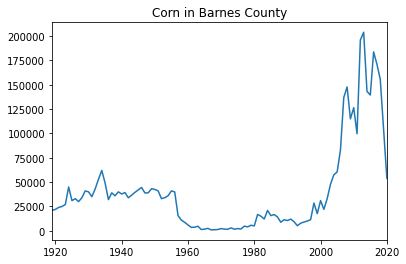

In [10]:
from matplotlib import pyplot as plt
plt.plot(corngraph['value'])
plt.xlim(corngraph.index.min(),corngraph.index.max())
plt.savefig('corn_alltime.jpg')
plt.title('Corn in Barnes County')
plt.show()

In [11]:
soygraph = splitter('BARNES',2020,1900,'SOYBEANS')

64


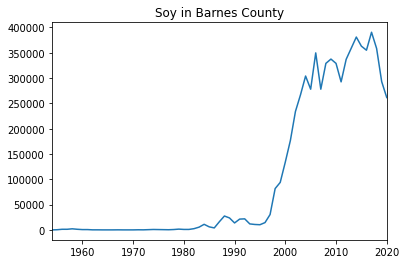

In [12]:
print(len(soygraph))
plt.plot(soygraph['value'])
plt.xlim(soygraph.index.min(),soygraph.index.max())
plt.title('Soy in Barnes County')
plt.savefig('soy_alltime.jpg')
plt.show()

In [13]:
wheatgraph = splitter('BARNES',2020,1900,'WHEAT','WHEAT - ACRES HARVESTED')

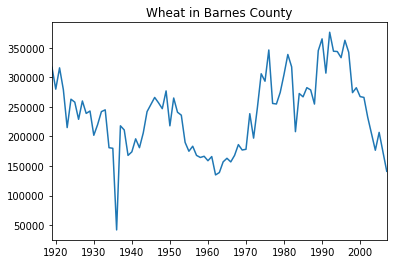

In [14]:
plt.plot(wheatgraph['value'])
plt.xlim(wheatgraph.index.min(),wheatgraph.index.max())
plt.title('Wheat in Barnes County')
plt.savefig('wheat_alltime.jpg')
plt.show()

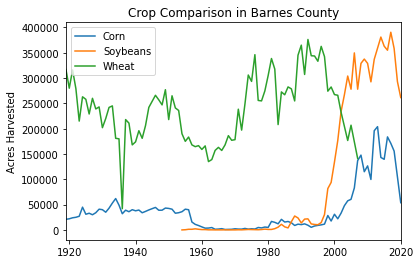

In [15]:
plt.plot(corngraph['value'],label='Corn')
plt.plot(soygraph['value'],label='Soybeans')
plt.plot(wheatgraph['value'],label='Wheat')
plt.legend()
plt.savefig('combinedcrops.jpg')
plt.title('Crop Comparison in Barnes County')
plt.xlim(1919,2020)
plt.ylabel('Acres Harvested')
plt.show()

#Wheat Visualizations for Barnes County

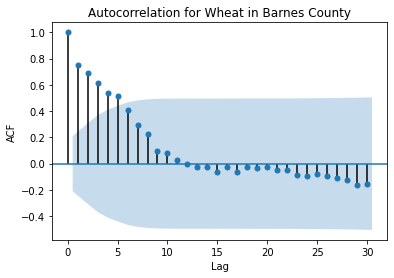

In [36]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(wheatgraph['value'],lags=30)
plt.title('Autocorrelation for Wheat in Barnes County')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.savefig('wheat-acf.jpg')
plt.show()

The above graph shows trends are sgnificant up to 5 years. And that there is no significant seasonal component involved in the wheat time series.

In [ ]:
#Detrend with lag 5 since that is the largest significant lag value for the acf graph.
wheat = wheatgraph['value']
wheatgraph['Moving Average'] = wheat.rolling(window=5).mean()
wheatgraph['detrend'] = wheat - wheatgraph['Moving Average']

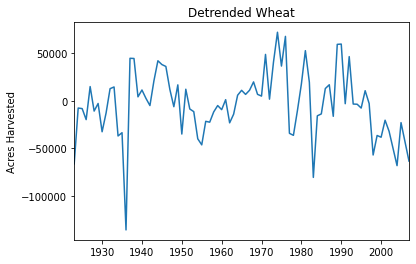

In [18]:
plt.plot(wheatgraph['detrend'])
plt.title('Detrended Wheat')
plt.xlim(wheatgraph['detrend'].dropna().index.min(),wheatgraph['detrend'].dropna().index.max())
plt.ylabel('Acres Harvested')
plt.savefig('dtrendwheat.jpg')
plt.show()

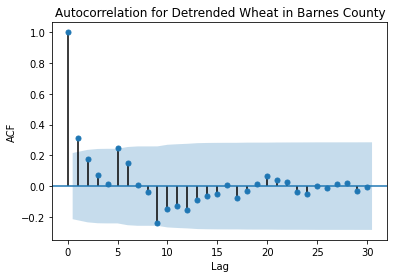

In [37]:
plot_acf(wheatgraph['detrend'].dropna(),lags=30)
plt.title('Autocorrelation for Detrended Wheat in Barnes County')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.savefig('dtrendwheat-acf.jpg')
plt.show()

In [20]:
m=5
seasons = []
for k in range(m):
    seasons += [wheatgraph.loc[wheatgraph.index.intersection(wheatgraph.index[::m]+k)]['detrend'].dropna().mean()]

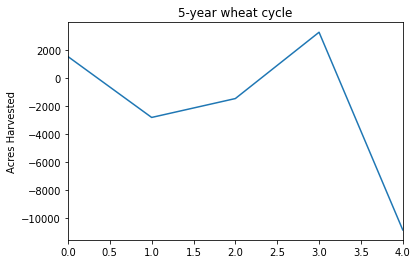

In [21]:
plt.plot(seasons)
plt.title(str(m)+'-year wheat cycle')
plt.xlim(0,m-1)
plt.savefig('wheatcycle.jpg')
plt.ylabel('Acres Harvested')
plt.show()

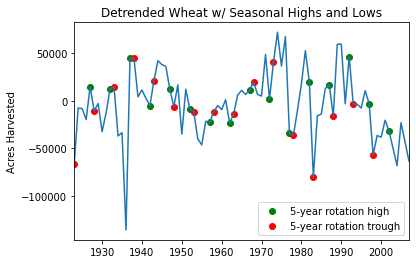

In [22]:
#Disregard these below
plt.plot(wheatgraph['detrend'])
plt.scatter((wheatgraph.index[::m]+3).values[:-1], wheatgraph.loc[wheatgraph.index.intersection(wheatgraph.index[::m]+3)]['detrend'].fillna(0),label=str(m)+'-year rotation high',c='green')
plt.scatter((wheatgraph.index[::m]+4).values[:-2], wheatgraph.loc[wheatgraph.index.intersection(wheatgraph.index[::m]+4)]['detrend'].fillna(0),label=str(m)+'-year rotation trough',c='red')
plt.xlim(wheatgraph['detrend'].dropna().index.min(),wheatgraph['detrend'].dropna().index.max())
plt.legend()
plt.title('Detrended Wheat w/ Seasonal Highs and Lows')
plt.savefig('dtrend-seasoncomparison-wheat.jpg')
plt.ylabel('Acres Harvested')
plt.show()

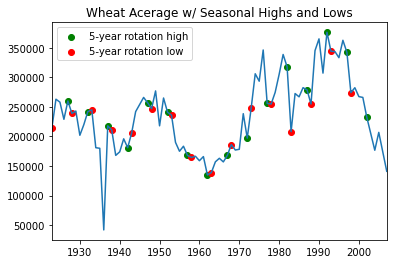

In [23]:
plt.plot(wheatgraph['value'])
plt.scatter((wheatgraph.index[::m]+3).values[:-1], wheatgraph.loc[wheatgraph.index.intersection(wheatgraph.index[::m]+3)]['value'].fillna(0),label=str(m)+'-year rotation high',c='green')
plt.scatter((wheatgraph.index[::m]+4).values[:-2], wheatgraph.loc[wheatgraph.index.intersection(wheatgraph.index[::m]+4)]['value'].fillna(0),label=str(m)+'-year rotation low',c='red')
plt.xlim(wheatgraph['detrend'].dropna().index.min(),wheatgraph['detrend'].dropna().index.max())
plt.legend()
plt.title('Wheat Acerage w/ Seasonal Highs and Lows')
plt.savefig('seasoncomparison-wheat.jpg')
plt.show()

#Corn Visualizations for Barnes County

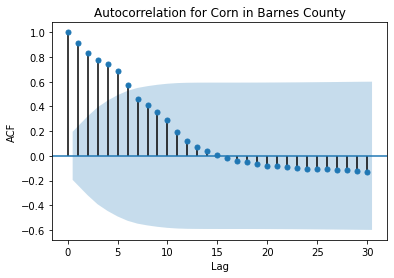

In [38]:
plot_acf(corngraph['value'],lags=30)
plt.title('Autocorrelation for Corn in Barnes County')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.savefig('corn-acf.jpg')
plt.show()

In [ ]:
corngraph['Moving Average'] = corngraph['value'].rolling(window=6).mean()
corngraph['detrend'] = corngraph['value'] - corngraph['Moving Average']

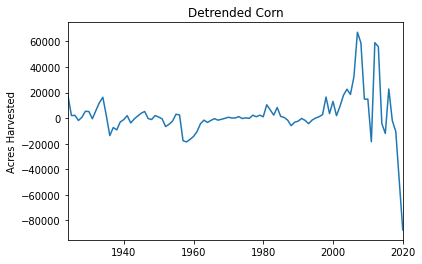

In [26]:
plt.plot(corngraph['detrend'])
plt.title('Detrended Corn')
plt.xlim(corngraph['detrend'].dropna().index.min(),corngraph['detrend'].dropna().index.max())
plt.ylabel('Acres Harvested')
plt.savefig('dtrendcorn.jpg')
plt.show()

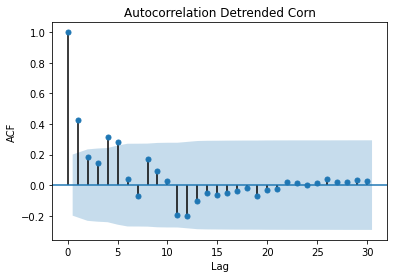

In [39]:
plot_acf(corngraph['detrend'].dropna(),lags=30)
plt.title('Autocorrelation Detrended Corn')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.savefig('dtrend-corn-acf.jpg')
plt.show()

In [42]:
m=4
seasons = []
corngraph = corngraph
for k in range(m):
    seasons += [corngraph.loc[corngraph.index.intersection(corngraph.index[::m]+k)]['detrend'].dropna().mean()]

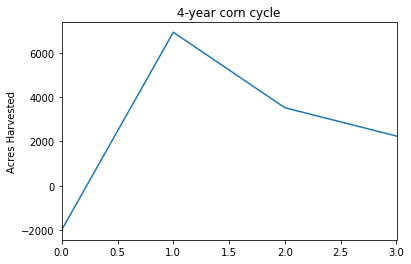

In [44]:
plt.plot(seasons)
plt.title(str(m)+'-year corn cycle')
plt.xlim(0,m-1)
plt.savefig('corn-cycle.jpg')
plt.ylabel('Acres Harvested')
plt.show()

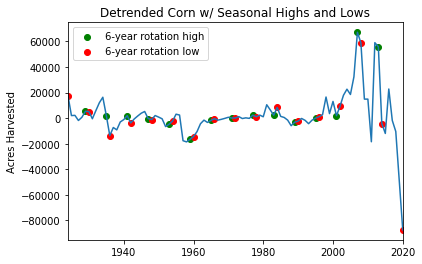

In [30]:
#plots comparing seasonal highs and lows to the graphs of the detrended and actual time series
plt.plot(corngraph['detrend'])
plt.scatter((corngraph.index[::m]+4).values[:-1], corngraph.loc[corngraph.index.intersection(corngraph.index[::m]+4)]['detrend'].fillna(0),label=str(m)+'-year rotation high',c='green')
plt.scatter((corngraph.index[::m]+5).values, corngraph.loc[corngraph.index.intersection(corngraph.index[::m]+5)]['detrend'].fillna(0),label=str(m)+'-year rotation low',c='red')
plt.xlim(corngraph['detrend'].dropna().index.min(),corngraph['detrend'].dropna().index.max())
plt.legend()
plt.title('Detrended Corn w/ Seasonal Highs and Lows')
plt.savefig('dtrend-seasoncomparison-corn.jpg')
plt.ylabel('Acres Harvested')
plt.show()

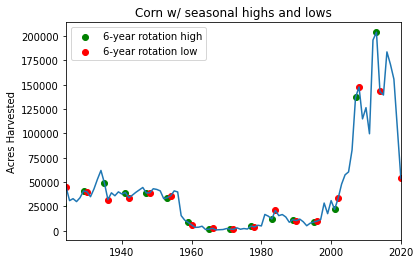

In [31]:
plt.plot(corngraph['value'])
plt.scatter((corngraph.index[::m]+4).values[:-1], corngraph.loc[corngraph.index.intersection(corngraph.index[::m]+4)]['value'].fillna(0),label=str(m)+'-year rotation high',c='green')
plt.scatter((corngraph.index[::m]+5).values, corngraph.loc[corngraph.index.intersection(corngraph.index[::m]+5)]['value'].fillna(0),label=str(m)+'-year rotation low',c='red')
plt.xlim(corngraph['detrend'].dropna().index.min(),corngraph['detrend'].dropna().index.max())

#Show and save image
plt.legend()
plt.title('Corn w/ seasonal highs and lows')
plt.savefig('seasoncomparison-corn.jpg')
plt.ylabel('Acres Harvested')
plt.show()

#Soybean Graphs Barnes County

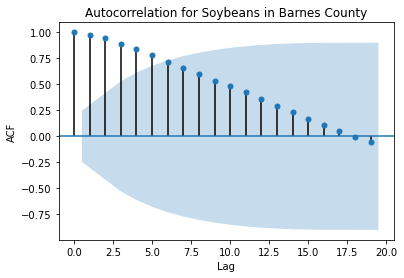

In [40]:
plot_acf(soygraph['value'])
plt.title('Autocorrelation for Soybeans in Barnes County')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.savefig('soy-acf.jpg')
plt.show()

In [ ]:
#lag significant up to 5 years
soygraph['Moving Average'] = soygraph['value'].rolling(window=5).mean()
soygraph['detrend'] = soygraph['value'] - soygraph['Moving Average']

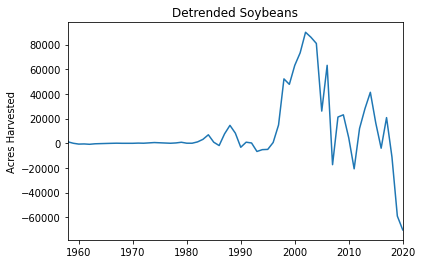

In [34]:
plt.plot(soygraph['detrend'])
plt.title('Detrended Soybeans')
plt.xlim(soygraph['detrend'].dropna().index.min(),soygraph['detrend'].dropna().index.max())
plt.ylabel('Acres Harvested')
plt.savefig('dtrendsoy.jpg')
plt.show()

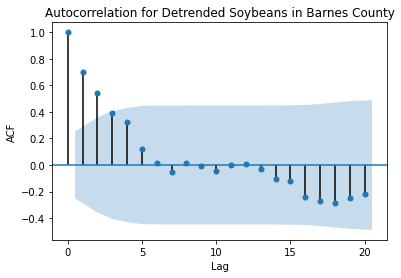

In [41]:
plot_acf(soygraph['detrend'].dropna(),lags=20)
plt.title('Autocorrelation for Detrended Soybeans in Barnes County')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.savefig('soy-dtrend-acf.jpg')
plt.show()